In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Imorting dataset from kaggle

In [ ]:
# generating dataset from directory

# Generating train dataset
data = tf.keras.utils.image_dataset_from_directory(directory = '/content/drive/MyDrive/shagundeep/dataset/Normal_Glaucoma',
                                                   color_mode = 'rgb',
                                                   batch_size = 64,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)

Found 2081 files belonging to 2 classes.


In [ ]:
labels = np.concatenate([y for x,y in data], axis=0)
values = pd.value_counts(labels)
values = values.sort_index()

In [ ]:
# getting class names
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}", end=", ")

0 = glaucoma, 1 = normal, 

#Visualizing the data

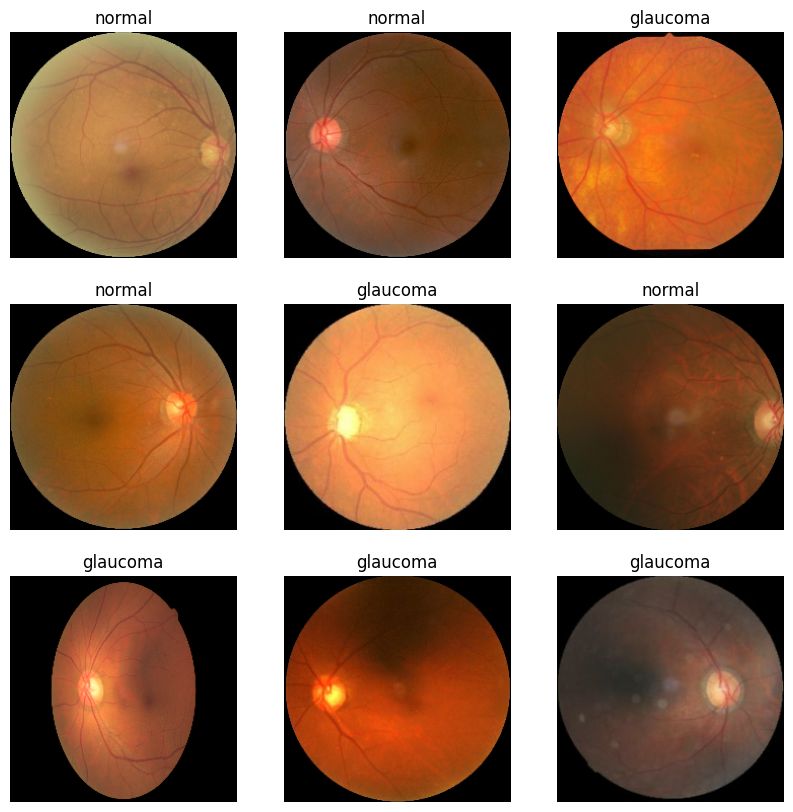

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Preprocessing data

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
# sns.heatmap(batch[0][1][:,:,1])

In [ ]:
sample = data.as_numpy_iterator().next()

In [ ]:
print("Minimum value of the scaled data:", sample[0].min())
print("Maximum value of the scaled data:", sample[0].max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


In [ ]:
print("There are", len(data), "batches in our data")

There are 33 batches in our data


Splitting the dataset

In [ ]:
train_size = int(len(data)*0.70)+1
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)
print("Train Size:", train_size)
print("Validation Size:", val_size)
print("Test Size:", test_size)


Train Size: 24
Validation Size: 6
Test Size: 3


In [ ]:
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

Preparing the dataset

In [ ]:
test_iter = test.as_numpy_iterator()
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
  try:
    batch = test_iter.next()
    test_set['images'] = np.concatenate((test_set['images'], batch[0]))
    test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
  except:
    break

In [ ]:
y_true = test_set['labels']

DenseNET Model

In [ ]:
base_model = tf.keras.applications.densenet.DenseNet121(include_top=True,
                                            input_shape=(224,224)+(3,),
                                            weights= 'imagenet')
model = Sequential()
# model.add(data_augmentation)
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2, activation='softmax'))

model.layers[0].trainable = False


In [ ]:
model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1000)              8062504   
                                                                 
 flatten_4 (Flatten)         (None, 1000)              0         
                                                                 
 dropout_4 (Dropout)         (None, 1000)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 8,068,506
Trainable params: 4,002
Non-trainable params: 8,064,504
________________________________________

In [ ]:
history = model.fit(
    train,
    validation_data=val,
    epochs = 100,
    # callbacks = EarlyStopping(monitor='loss', patience=5)
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - 28s 811ms/step - loss: 0.6673 - accuracy: 0.5977 - val_loss: 0.6781 - val_accuracy: 0.5625
Epoch 2/100
24/24 [==============================] - 20s 761ms/step - loss: 0.6263 - accuracy: 0.7064 - val_loss: 0.6734 - val_accuracy: 0.5573
Epoch 3/100
24/24 [==============================] - 20s 755ms/step - loss: 0.5961 - accuracy: 0.7188 - val_loss: 0.6624 - val_accuracy: 0.7318
Epoch 4/100
24/24 [==============================] - 20s 757ms/step - loss: 0.5739 - accuracy: 0.7513 - val_loss: 0.6609 - val_accuracy: 0.7214
Epoch 5/100
24/24 [==============================] - 20s 749ms/step - loss: 0.5558 - accuracy: 0.7552 - val_loss: 0.6482 - val_accuracy: 0.7474
Epoch 6/100
24/24 [==============================] - 20s 752ms/step - loss: 0.5468 - accuracy: 0.7559 - val_loss: 0.6385 - val_accuracy: 0.7396
Epoch 7/100
24/24 [==============================] - 20s 746ms/step - loss: 0.5340 - accuracy: 0.7604 - val_loss: 0.6297 - val_accuracy: 0.7448
Epoc

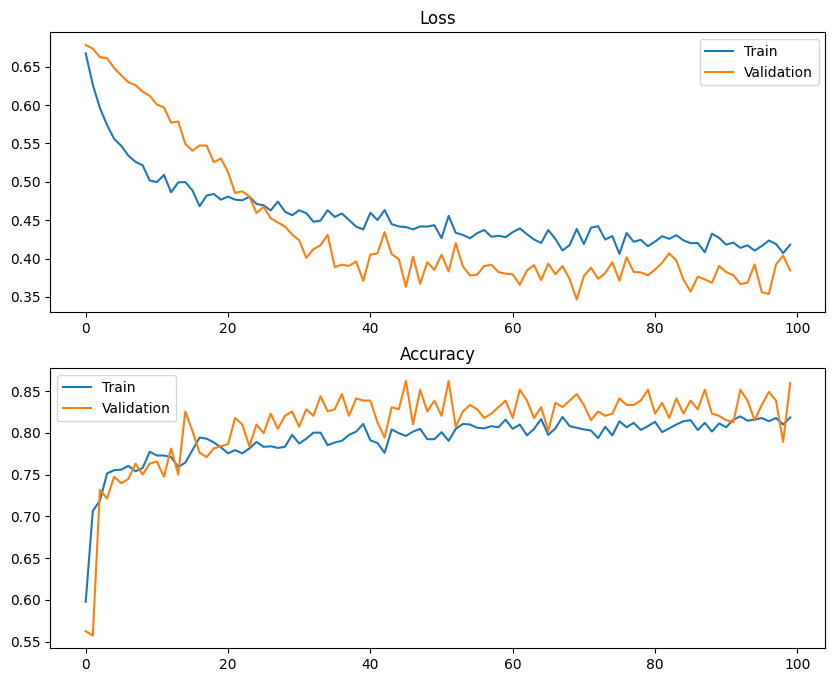

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].plot(history.history["loss"], label="Train")
ax[0].plot(history.history["val_loss"], label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], label="Train")
ax[1].plot(history.history["val_accuracy"], label="Validation")
ax[1].title.set_text("Accuracy")
ax[1].legend()

plt.show()


In [ ]:
y_true

array([1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
       0., 1., 1., 0., 1., 1., 1., 1.])

In [ ]:

y_pred = np.argmax(model.predict(test_set['images']), 1)

6/6 [==============================] - 4s 294ms/step


In [ ]:
y_pred

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0])

In [ ]:
#y_pred_prob = np.argmax(model.predict_proba(test_set['images']), 1)

def predict_prob(number):
  return [number[0],1-number[0]]

y_prob = np.array(list(map(predict_prob, model.predict(test_set['images']))))
y_prob = y_prob[::,1]
y_prob

6/6 [==============================] - 0s 85ms/step


array([9.24589209e-01, 8.06868076e-04, 2.59726644e-02, 3.89667153e-02,
       1.27262414e-01, 3.79231334e-01, 1.59955025e-02, 1.61455274e-02,
       7.68467903e-01, 3.26926053e-01, 4.49854136e-03, 2.15144277e-01,
       3.92585933e-01, 8.51745069e-01, 6.85627908e-01, 5.99095821e-02,
       3.48925591e-04, 1.37020350e-02, 7.49093115e-01, 8.55561763e-01,
       7.41987824e-02, 3.03080678e-02, 7.48859942e-01, 8.89956951e-04,
       3.23133945e-01, 3.92647624e-01, 9.93787646e-02, 1.77631319e-01,
       6.86673909e-01, 3.57825160e-02, 6.32508457e-01, 7.90337160e-01,
       2.44752169e-02, 8.16923380e-03, 4.80339229e-01, 1.34089708e-01,
       5.76243371e-01, 7.74548709e-01, 5.14931917e-01, 9.69133375e-01,
       5.59258908e-01, 1.72257423e-04, 7.96724379e-01, 7.72897571e-01,
       4.81216431e-01, 7.23750949e-01, 7.08391428e-01, 5.23921251e-02,
       6.55614316e-01, 1.01764798e-01, 7.03226298e-01, 6.80370063e-01,
       6.50360167e-01, 2.21015513e-01, 3.82432640e-01, 3.57346535e-02,
      

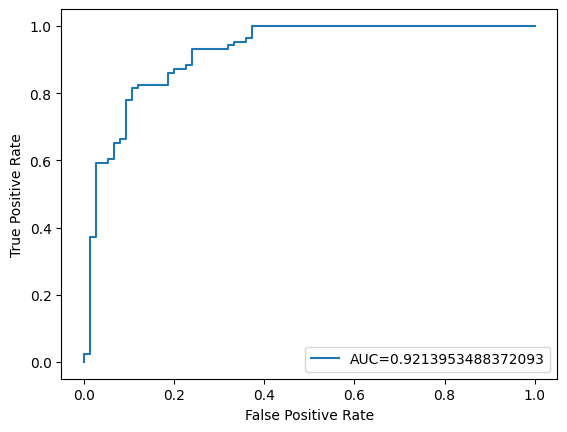

In [ ]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_true,  y_prob)
auc = metrics.roc_auc_score(y_true,  y_prob)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()



In [ ]:
pip install sklearn.metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)
ERROR: No matching distribution found for sklearn.metrics


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_true, y_pred, target_names = class_names))

              precision    recall  f1-score   support

    glaucoma       0.78      0.89      0.83        75
      normal       0.89      0.78      0.83        86

    accuracy                           0.83       161
   macro avg       0.84      0.84      0.83       161
weighted avg       0.84      0.83      0.83       161



Text(0.5, 1.0, 'Confusion Matrix')

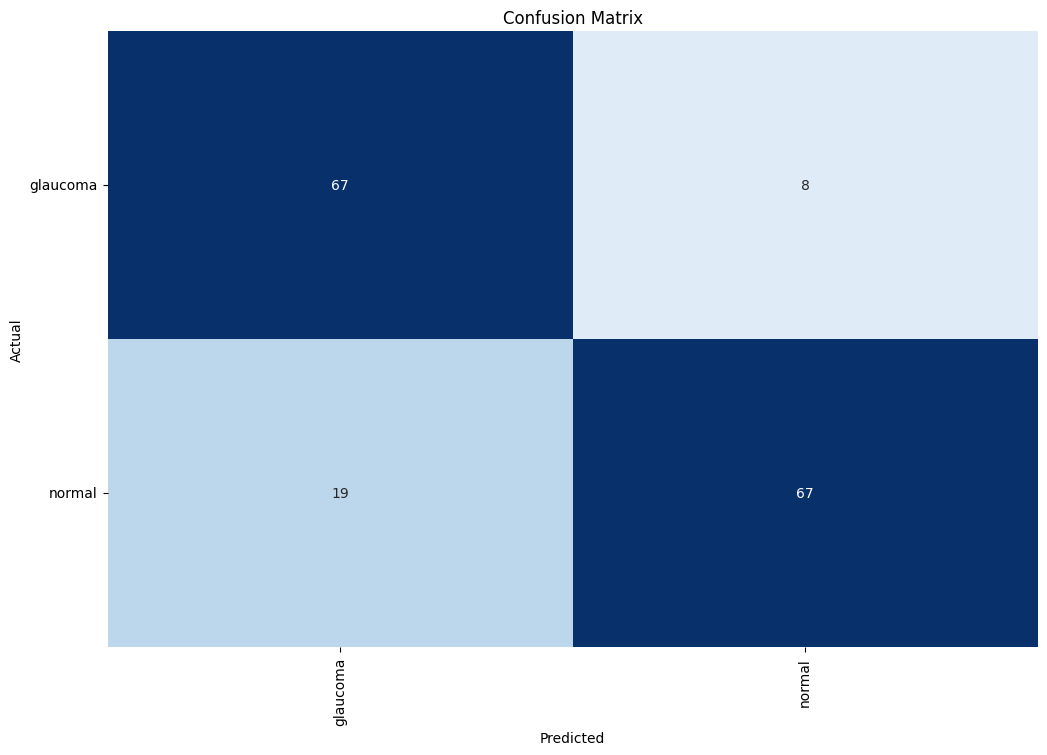

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(2)+.5, class_names, rotation=90)
plt.yticks(np.arange(2)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [ ]:
sensitivity = np.diag(cm)/np.sum(cm,axis=1)
specificity = []
for i in range(cm.shape[0]):
  tn = np.delete(cm, i ,axis=0)[:,np.delete(np.arange(cm.shape[0]),i)]
  fp = np.delete(cm[i:],i)
  specificity.append(np.sum(tn)/ (np.sum(tn)+np.sum(fp)))

In [ ]:
overall_sensitivity = np.mean(sensitivity)
overall_specificity = np.mean(specificity)

In [ ]:
print(f'Overall Sensitivity: {overall_sensitivity}')
print(f'Overall Specficity: {overall_specificity}')

Overall Sensitivity: 0.8362015503875969
Overall Specficity: 0.597609417882421
